In [1]:
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch.callbacks import ModelCheckpoint
from Custom_Callbacks import GradientNormLogger
from lightning.pytorch.profilers import PyTorchProfiler
import torch
import torch.nn.functional as F
from torch import nn
from torch import optim
import torch.testing
from torchvision.models import vgg16, VGG16_Weights
import torchvision
from pydantic import BaseModel
from jaxtyping import Float, Shaped, Int, Bool, jaxtyped
from typing import Tuple, Callable, Optional, Any, Dict, Union
from typeguard import typechecked as typechecker
from lightning import LightningModule, Trainer
from lightning.pytorch.tuner.tuning import Tuner
from einops import rearrange, reduce, repeat
from DataModule import DataModule
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import csv
import numpy as np

__file__ = "main.ipynb"
import ipytest
import pytest


Tensor = torch.Tensor
Array = np.ndarray

LABEL_FG = 1
LABEL_BG = 0
LABEL_IGNORE = -1

device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.set_float32_matmul_precision('medium')
torch.manual_seed(42)

ipytest.autoconfig()

{'aeroplane': 1, 'bicycle': 2, 'bird': 3, 'boat': 4, 'bottle': 5, 'bus': 6, 'car': 7, 'cat': 8, 'chair': 9, 'cow': 10, 'diningtable': 11, 'dog': 12, 'horse': 13, 'motorbike': 14, 'person': 15, 'pottedplant': 16, 'sheep': 17, 'sofa': 18, 'train': 19, 'tvmonitor': 20}


In [2]:
with open('./pascal_label_map.csv', mode='r') as file:
    csv_reader = csv.reader(file)
    LABEL_MAP = {key.strip("'"): int(value) for key, value in csv_reader}

LABEL_MAP_INV = {value: key for key, value in LABEL_MAP.items()}

In [3]:
class Hyperparameter(BaseModel):
    # --- RPN ---
    feature_map_channels: int = 512
    rpn_hidden_channels: int = 512
    aspect_ratios: tuple = (0.5, 1, 2)
    scales: tuple =  (128, 256, 512)
    rpn_high_iou_thres: float = 0.7
    rpn_low_iou_thres: float = 0.3
    rpn_batch_size: int = 256
    rpn_positive_fraction: float = 0.5
    rpn_regression_beta: float = 1/9.
    rpn_pre_nms_topK: int = 12000
    rpn_min_size: int = 16
    rpn_nms_iou_thres: float = 0.7
    rpn_post_nms_topK: int = 2000

    # --- ROI ---
    # training
    roi_align_output_size: int = 7
    roi_align_num_sampling_points: int = 2
    roi_hidden_layer_size: int = 4096
    num_classes: int = 20
    roi_high_iou_thres: float = 0.5
    roi_low_iou_thres: float = 0.1

    roi_batch_size: int = 128
    roi_positive_fraction: float = 0.33
    roi_regression_beta: float = 1/9.

    # prediction
    roi_cls_score_thres: float = 0.05
    roi_min_box_size: int = 16
    roi_nms_thres: float = 0.3
    roi_max_detections_per_image: int = 7

    



    class Config:
        arbitrary_types_allowed = True


In [4]:
class Utilities:
    @staticmethod
    def calculate_iou(boxes1: Float[Tensor, 'N1 4'], boxes2: Float[Tensor, 'N2 4']) -> Float[Tensor, 'N1 N2']:
        """
        Calculates the Intersection over Union (IoU) between each combination betweeb a sets of boxes.

        IoU is defined as:
            IoU = Area(Intersection) / Area(Union)

        Args:
            boxes1: Tensor of shape (N1, 4), with N number boxes in set 1
                            Each row represents a box in the format [xmin, ymin, xmax, ymax].
            boxes2: Tensor of shape (N2, 4), number of boxes in set2
                            Each row represents a box in the format [xmin, ymin, xmax, ymax].

        Returns:
            iou_matrix: Tensor of shape (N1, N2), where each element [i, j] is the IoU
                        between the i-th box in set 1 and the j-th box in set 2.
        """

        # 1. Calc ara of boxes
        areas1: Float[Tensor, 'N1'] = (boxes1[:, 2] - boxes1[:, 0]) * (boxes1[:, 3] - boxes1[:, 1])
        areas2: Float[Tensor, 'N2'] = (boxes2[:, 2] - boxes2[:, 0]) * (boxes2[:, 3] - boxes2[:, 1])

        # 2. find the edges of intersction
        inter_left_edge: Float[Tensor, 'N1 N2'] = torch.max(boxes1[:, None, 0], boxes2[None , :, 0])
        inter_right_edge: Float[Tensor, 'N1 N2'] = torch.min(boxes1[:, None, 2], boxes2[None , :, 2])
        inter_top_edge: Float[Tensor, 'N1 N2'] = torch.max(boxes1[:, None, 1], boxes2[None , :, 1])
        inter_bottom_edge: Float[Tensor, 'N1 N2'] = torch.min(boxes1[:, None, 3], boxes2[None , :, 3])

        # 3. Calculate width and height of the intersection box
        # If the boxes don't overlap, the width or height will be negative.
        # In this case clamp to ie no intersection box ara
        inter_width: Float[Tensor, 'N1 N2'] = torch.clamp(inter_right_edge - inter_left_edge, min=0)
        inter_height: Float[Tensor, 'N1 N2'] = torch.clamp(inter_bottom_edge - inter_top_edge, min=0)

        # 4. Calculate intersection area
        intersection_area: Float[Tensor, 'N1 N2'] = inter_height * inter_width

        # 5. Calculate union area
        # Union = Area(anchor) + Area(target) - Area(intersection)
        union_area: Float[Tensor, 'N1 N2'] = areas1[:, None] + areas2[None, :] - intersection_area

        # 6. IoU = Area(Intersection) / Area(Union)
        # Add a small epsilon to the denominator to avoid division by zero.
        eps: float = 1e-6
        ious: Float[Tensor, 'N1 N2'] = torch.clamp(intersection_area / (union_area + eps), min=0, max=1)

        return ious
    

    @staticmethod
    def apply_transform_params(boxes: Float[Tensor, 'N 4'], transform_params: Float[Tensor, 'N 4']) -> Float[Tensor, 'N 4']:
        """
        Applies transformation (tcx, tcy, tw, th) to boxes

        Formulas:
            new_cx = tx * box_w + box_cx
            new_cy = ty * box_h + box_cy
            new_w = exp(tw) * box_w
            new_h = exp(th) * box_h

        Args:
            boxes Float[Tensor, 'N 4']: Boxes in [xmin, ymin, xmax, ymax] format.
                                     Shape: (N, 4).
            transform_params Float[Tensor, 'N 4']: Transformation parameters [tcx, tcy, tw, th].
                                         Shape: (N, 4).

        Returns:
            Float[Tensor, 'N 4']: Transformed boxes in [xmin, ymin, xmax, ymax] format.
                      Shape: (N, 4).
        """
    
        # 1. Convert boxes to [cx, cy, h, w] format
        box_widths: Float[Tensor, 'N'] = boxes[..., 2] - boxes[..., 0]
        box_heights: Float[Tensor, 'N'] = boxes[..., 3] - boxes[..., 1]

        boxes_cx: Float[Tensor, 'N'] = boxes[..., 0] + box_widths / 2
        boxes_cy: Float[Tensor, 'N'] = boxes[..., 1] + box_heights / 2

        # 2. Calculate new coords in [cx, cy, h, w]
        new_width: Float[Tensor, 'N'] = box_widths * torch.exp(transform_params[..., 2])
        new_height: Float[Tensor, 'N'] = box_heights * torch.exp(transform_params[..., 3])

        new_cx: Float[Tensor, 'N'] = transform_params[..., 0] * box_widths + boxes_cx
        new_cy: Float[Tensor, 'N'] = transform_params[..., 1] * box_heights + boxes_cy

        # 3. Convert new boxes coords to [xmin, ymin, xmax, ymax]
        new_xmin: Float[Tensor, 'N'] = new_cx - new_width / 2
        new_ymin: Float[Tensor, 'N'] = new_cy - new_height / 2

        new_xmax: Float[Tensor, 'N'] = new_xmin + new_width
        new_ymax: Float[Tensor, 'N']= new_ymin + new_height

        # 4. Stack the [xmin, ymin, xmax, ymax]  into one tensor 
        transformed_boxes: Float[Tensor, 'N 4'] = torch.stack([new_xmin, new_ymin, new_xmax, new_ymax], dim=-1)

        return transformed_boxes


    @staticmethod
    def calculate_transform_params(boxes1: Float[Tensor, 'N 4'], boxes2: Float[Tensor, 'N 4']) -> Float[Tensor, 'N 4']:
        """
        Calculates transforamtion parameters between two sets of boxes given in [xmin, ymin, xmax, ymax]

        Description:
            - It then computes the transforamion (tcx, tcy, tw, th) required
              to transform a box in boxes1 to its corresponding box in boxes2
            - The transformation is parameterized to be scale-invariant:
                tx = (box2_cx - box1_cx) / box1_w
                ty = (box2_cy - box1_cy) / box1_h
                tw = log(box2_w / box1_w)
                th = log(box2_h / box1_h)

        Args:
            boxes1: N Boxes in [xmin, ymin, xmax, ymax] format.
            boxes2: N corresponding target boxes in [xmin, ymin, xmax, ymax] format.

        Returns:
            transformation_params: Tensor shape (N, 4), containing
                                the transformation parameters [tcx, tcy, tw, th] for each box.
        """

        # 1. Change the box coords from [xmin, ymin, xmax, ymax] to [cx, cy, tw, th]
        eps = 1e-6 # use eps to limit width and height to prevent devsion and ln of zero
        boxes1_width: Float[Tensor, 'N'] = (boxes1[:, 2] - boxes1[:, 0]).clamp(min=eps)
        boxes1_height: Float[Tensor, 'N'] = (boxes1[:, 3] - boxes1[:, 1]).clamp(min=eps)

        boxes2_width: Float[Tensor, 'N'] = (boxes2[:, 2] - boxes2[:, 0]).clamp(min=eps)
        boxes2_height: Float[Tensor, 'N'] = (boxes2[:, 3] - boxes2[:, 1]).clamp(min=eps)

        boxes1_cx: Float[Tensor, 'N'] = boxes1[:, 0] + boxes1_width / 2
        boxes1_cy: Float[Tensor, 'N'] = boxes1[:, 1] + boxes1_height / 2

        boxes2_cx: Float[Tensor, 'N'] = boxes2[:, 0] + boxes2_width / 2
        boxes2_cy: Float[Tensor, 'N'] = boxes2[:, 1] + boxes2_height / 2

        # 2. Calculate transfomation parameters
        t_cx: Float[Tensor, 'N'] = (boxes2_cx - boxes1_cx) / boxes1_width
        t_cy: Float[Tensor, 'N'] = (boxes2_cy - boxes1_cy) / boxes1_height

        t_h: Float[Tensor, 'N'] = torch.log(boxes2_height / boxes1_height)
        t_w: Float[Tensor, 'N'] = torch.log(boxes2_width / boxes1_width)

        # 3. Stack transform parameters into one tensor
        transform_params: Float[Tensor, 'N 4'] = torch.stack((t_cx, t_cy, t_w, t_h), dim=-1)

        return transform_params


    @staticmethod
    def torch_choice_no_replace(tensor: Shaped[Tensor, 'N'], num_samples: int) -> Shaped[Tensor, 'M']:
        """
        Randomly samples 'num_samples' unique elements from the input 'tensor'.
        Returns empty tensor if num_samples is 0

        Args:
            tensor (torch.Tensor): 1D tensor containing the population to sample from.
            num_samples (int): The number of unique samples to draw.

        Returns:
            torch.Tensor: A 1D tensor containing the sampled elements.

        Raises:
            ValueError: If num_samples is negative or greater than tensor length.
        """

        if num_samples < 0:
            raise ValueError(f"Number of samples must be non-negative, got {num_samples}")
        # Allow sampling all elements if num_samples == tensor_length
        elif num_samples > len(tensor):
            raise ValueError(f"Number of samples {num_samples} cannot be larger than input tensor length {len(tensor)} for sampling without replacement.")
        # Handle num_samples == 0 explicitly for clarity and correct empty tensor
        elif num_samples == 0:
             return torch.empty((0,), dtype=tensor.dtype, device=tensor.device) # Match dtype
        
        return tensor[torch.randperm(len(tensor))[:num_samples]]
    

    @staticmethod
    def sample_balanced_batch(positive_idxs: Int[Tensor, 'N'], negative_idxs: Int[Tensor, 'M'], batch_size: int, positive_fraction: float) -> Tuple[Int[Tensor, 'num_positive_actual'], Int[Tensor, 'num_negative_actual']]:
        """
        Samples a batch of indices from provided positive and negative index sets,
        aiming for a specific fraction of positive samples.

        Note:
            The total number of returned indices (positive + negative) might be
            less than `batch_size` if there are not enough available indices in
            either `positive_idxs` or `negative_idxs` to meet the desired counts
            calculated from `positive_fraction`. In this case the sampled batch
            may be smaller than the desired batch size

        Args:
            positive_idxs (Int[Tensor, 'N']): A 1D tensor containing indices
                classified as positive examples.
            negative_idxs (Int[Tensor, 'M']): A 1D tensor containing indices
                classified as negative examples.
            batch_size (int): The total desired number of samples in the batch.
            positive_fraction (float): The desired fraction of positive samples
                in the final sampled batch (e.g., 0.25 for 25% positives).

        Returns:
            Tuple[Int[Tensor, 'num_positive_actual'], Int[Tensor, 'num_negative_actual']]:
            A tuple containing two 1D integer tensors:
                - The first tensor holds the sampled positive indices. Its size (`num_positive_actual`)
                - The second tensor holds the sampled negative indices. Its size (`num_negative_actual`)
        """

        # 1. get the number of desired postive and negative samples
        num_positive_desired: int = int(batch_size * positive_fraction)
        num_negative_desired: int = batch_size - num_positive_desired

        # 2. get number of availbe postive and negative samples
        num_positive_available: int = len(positive_idxs)
        num_negative_available: int = len(negative_idxs)

        # 3. Determine ACTUAL number of positives and negative samples
        # If num_available < num_desired, this takes all available.
        num_positive_actual: int = min(num_positive_available, num_positive_desired)
        num_negative_actual: int = min(num_negative_available, num_negative_desired)

        # 4. Sample a random choice of idxs
        positive_idxs_choice: Int[Tensor, 'num_positive_actual'] = Utilities.torch_choice_no_replace(positive_idxs, num_positive_actual)
        negative_idxs_choice: Int[Tensor, 'num_negative_actual'] = Utilities.torch_choice_no_replace(negative_idxs, num_negative_actual)

        return positive_idxs_choice, negative_idxs_choice
    

    @staticmethod
    def clamp_boxes_to_image_boundry(boxes: Float[Tensor, 'N 4'], image_shape: Tuple[int, int]) -> Float[Tensor, 'N 4']:
        """
        Clamps bounding box coordinates to stay within image boundaries.

        Takes a tensor of bounding boxes in [xmin, ymin, xmax, ymax] format
        and modifies them such that no coordinate value exceeds the image
        dimensions (height and width) extracted from the last two elements
        of `image_shape`.

        - x-coordinates (xmin, xmax) are clamped to the range [0, image_width].
        - y-coordinates (ymin, ymax) are clamped to the range [0, image_height].

        Note: This function modifies the input `boxes` tensor in-place but
              also returns it.

        Args:
            boxes (Float[Tensor, 'N 4']): A tensor of N bounding boxes, where
                each box is represented as [xmin, ymin, xmax, ymax].
            image_shape (Tuple[int, int]): A tuple representing the shape of
                the image. The height and width are extracted from the last
                two dimensions (e.g., (H, W) or (C, H, W) or (B, C, H, W)).

        Returns:
            Float[Tensor, 'N 4']: The input `boxes` tensor with coordinates
            clamped to the image boundaries.
        """

        # 1. Get image height and width
        image_height, image_width = image_shape[-2:]

        # 2. Clamp boxes to image size
        boxes[..., 0] = boxes[..., 0].clamp(min=0, max=image_width)
        boxes[..., 1] = boxes[..., 1].clamp(min=0, max=image_height)
        boxes[..., 2] = boxes[..., 2].clamp(min=0, max=image_width)
        boxes[..., 3] = boxes[..., 3].clamp(min=0, max=image_height)

        return boxes




    


In [5]:
class RPN(nn.Module):
    def __init__(self, hparams: Hyperparameter) -> None:
        super().__init__()
        # save hprams and device to member variable
        self.hparams = hparams
        self.device = device

        in_channels = self.hparams.feature_map_channels # depth of feature_map
        hidden_channels = self.hparams.rpn_hidden_channels
        
        num_aspect_ratios = len(self.hparams.aspect_ratios)
        num_scales = len(self.hparams.scales)
        num_anchor_box_types: int = num_aspect_ratios * num_scales
        
        self.k = num_anchor_box_types

        # Intermidate conv to gather inforamtion from sourounding pixels
        # use padding so their is no reduction in size
        self.intermediate_conv = nn.Conv2d(in_channels=in_channels, out_channels=hidden_channels, kernel_size=3, stride=1, padding=1)

        self.intermediate_conv_activation = nn.ELU()

        self.cls_conv = nn.Conv2d(in_channels=hidden_channels, out_channels=self.k, kernel_size=1, stride=1)

        self.transform_param_conv = nn.Conv2d(in_channels=hidden_channels, out_channels=4*self.k, kernel_size=1, stride=1)


        # init weights
        for layer in [self.intermediate_conv, self.cls_conv, self.transform_param_conv]:
            # Consider Kaiming init or a smaller std for normal init
            torch.nn.init.kaiming_normal_(layer.weight, mode='fan_out', nonlinearity='relu') # Adjust nonlinearity if using ELU strictly
            # Or: torch.nn.init.normal_(layer.weight, std=0.01)
            torch.nn.init.constant_(layer.bias, 0)

    def forward(self, feature_map: Float[Tensor, 'C_in H W']) -> Tuple[Float[Tensor, 'H*W*k'], Float[Tensor, 'H*W*k 4']]:
        """
        Processes a single feature map through the RPN head.

        Args:
            feature_map: Input feature map (without batch dimension).

        Returns:
            A tuple containing:
            - cls_logits_flat: Flattened classification logits. Shape (H*W*k).
            - transform_param_pred_flat: Flattened regression parameters. Shape (H*W*k, 4).
        """
        
        # 0. Add batch dimension for Conv layers
        feature_map_batched: Float[Tensor, '1 C_in H W'] = feature_map.unsqueeze(0)

        # 1. Get intermediate representation
        intermediate_features: Float[Tensor, '1 C_hidden H W'] = self.intermediate_conv(feature_map_batched)
        intermediate_features: Float[Tensor, '1 C_hidden H W'] = self.intermediate_conv_activation(intermediate_features)

        # 2. Get the cls logits
        cls_logits: Float[Tensor, '1 k H W'] = self.cls_conv(intermediate_features)

        cls_logits_flat: Float[Tensor, 'H*W*k'] = rearrange(cls_logits, '1 k H W -> (H W k)')

        # 3. Get transform param pred
        transform_param_pred: Float[Tensor, '1 4k H W'] = self.transform_param_conv(intermediate_features)

        transform_param_pred_flat: Float[Tensor, 'H*W*k 4'] = rearrange(transform_param_pred, '1 (k four) H W -> (H W k) four', four=4)
        
        return cls_logits_flat, transform_param_pred_flat
    

    def gen_zero_centered_anchores(self) -> Float[Tensor, 'k 4']:
        """
        Generates k anchor boxes centered at (0,0) in image space dimensions.

        Uses the `aspect_ratios` and `scales` defined in `self.hparams`.
        The number of anchors generated is k = len(aspect_ratios) * len(scales).

        Derivation Logic:
            - Normalized space assumes area = 1 (height_norm * width_norm = 1).
            - Aspect ratio definition: aspect_ratio = width_norm / height_norm.
            - Solving gives:
                - width_norm = sqrt(aspect_ratio)
                - height_norm = 1 / sqrt(aspect_ratio)
            - `scale` hyperparameter represents the desired base size (e.g., edge length
              for a square anchor) in image space pixels. This is used directly as the
              linear scaling factor.
            - Image space dimensions:
                - height = height_norm * sqrt(scale)
                - width = width_norm * sqrt(scale)

        Returns:
            Float[Tensor, 'k 4']: A tensor containing k anchor boxes centered
            at (0,0). Each row represents a box in the format
            [xmin, ymin, xmax, ymax].
        """

        # 0. Get hparmas
        aspect_ratios: Float[Tensor, 'aspect_ratio'] = torch.tensor(self.hparams.aspect_ratios, dtype=torch.float, device=self.device)
        scales: Float[Tensor, 'scales'] = torch.tensor(self.hparams.scales, dtype=torch.float, device=self.device)

        # 1. Calculate normalized height and width based on aspect ratios
        heights_norm: Float[Tensor, 'aspect_ratios'] = 1 / torch.sqrt(aspect_ratios)
        widths_norm: Float[Tensor, 'aspect_ratios'] = torch.sqrt(aspect_ratios)

        # 2. Calculate image space height/width for all k combinations via outer product, by scaling the normalized heiht and width by the scale factors
        heights: Float[Tensor, 'aspect_ratios scales'] = torch.outer(heights_norm, scales)
        widths: Float[Tensor, 'aspect_ratios scales'] = torch.outer(widths_norm, scales)

        # 3. Flatten to get height and width for each of the k anchors
        heights: Float[Tensor, 'k'] = rearrange(heights, 'aspect_ratios scales -> (aspect_ratios scales)')
        widths: Float[Tensor, 'k'] = rearrange(widths, 'aspect_ratios scales -> (aspect_ratios scales)')

        # 4. Compute box coordinates (xmin, ymin, xmax, ymax) centered at (0, 0)
        xmin: Float[Tensor, 'k'] = -widths / 2.
        ymin: Float[Tensor, 'k'] = -heights / 2.
        xmax: Float[Tensor, 'k'] = widths / 2.
        ymax: Float[Tensor, 'k'] = heights / 2.

        zero_centered_anchores: Float[Tensor, 'k 4'] = torch.stack([xmin, ymin, xmax, ymax], dim=-1)

        return zero_centered_anchores
    

    def map_feature_centers_to_image_coords(self, feature_map_shape: Tuple[int, int], image_shape: Tuple[int, int]) -> Float[Tensor, 'feat_h feat_w 4']:
        """
        Calculates the image space coordinates corresponding to the center
        of each cell in a feature map grid.

        Generates a grid representing the (x, y) coordinates in the original
        image space that align with the center of each feature map cell.
        This uses proportional scaling based on the relative sizes of the
        feature map and the image.

        Args:
            feature_map_shape (Tuple[int, int]): The shape of the feature map,
                typically (height, width). Can also accept shapes like
                (C, H, W) or (B, C, H, W).
            image_shape (Tuple[int, int]): The shape of the original image,
                typically (height, width). Can also accept shapes like
                (C, H, W) or (B, C, H, W).

        Description:
            - Generates a grid of feature map coordinates using meshgrid.
            - Converts all feature map coordinates to image space using proportional scaling:
                - The relationship between feature map and image space is:
                    - x_feat / feat_width = x_img / img_width
                    - y_feat / feat_height = y_img / img_height
                - Rearranging the above gives:
                    - x_img = (x_feat / feat_width) * img_width
                    - y_img = (y_feat / feat_height) * img_height
            - This ensures that all feature map points are mapped to their corresponding positions in image space.

        Returns:
            Float[Tensor, 'feat_h feat_w 4']: A tensor where each element [h, w]
            contains the coordinates [x_img, y_img, x_img, y_img] in image space
            corresponding to the center of the feature map cell (h, w). This
            format is suitable for broadcasting addition with zero-centered
            anchor boxes of shape (k, 4) to produce anchors positioned
            correctly across the image grid.
        """

        # 0. Extract dimensions (use last two dimensions for H, W)
        image_height, image_width = image_shape[-2:]
        feature_height, feature_width = feature_map_shape[-2:]

        # 1. Create 1D coordinate ranges for feature map cell centers
        # Add 0.5 to shift coords from top-left corner (0,0) to cell center (0.5, 0.5)
        feature_y_coords: Float[Tensor, 'feat_h']  = torch.arange(0, feature_height, dtype=torch.float32, device=self.device) + 0.5
        feature_x_coords: Float[Tensor, 'feat_w'] = torch.arange(0, feature_width, dtype=torch.float32, device=self.device) + 0.5

        # 2. Create 2D coordinate grids for feature map cell centers
        # feat_mesh_y shape: (feat_h, feat_w) (contains y coordinates of feature for each point feat_h feat_w)
        # feat_mesh_x shape: (feat_h, feat_w) (contains x coordinates of feature for each point feat_h feat_w)
        feat_mesh_y, feat_mesh_x = torch.meshgrid(feature_y_coords, feature_x_coords, indexing='ij')

        # 3. Map feature map grid centers to image space coordinates
        image_mesh_y: Float[Tensor, 'feat_h feat_w'] = feat_mesh_y * (image_height / feature_height)
        image_mesh_x: Float[Tensor, 'feat_h feat_w'] = feat_mesh_x * (image_width / feature_width)

        # 5. Stack coordinates into the desired (H, W, 4) format [x, y, x, y]
        # This format facilitates adding to zero-centered anchors [axmin, aymin, axmax, aymax]
        # Resulting shape: (feat_h, feat_w, 4)
        center_coords_img_grid: Float[Tensor, 'feat_h feat_w 4'] = torch.stack([image_mesh_x, image_mesh_y, image_mesh_x, image_mesh_y],dim=-1)

        return center_coords_img_grid
    

    def gen_anchors(self, feature_map_shape: Tuple[int, int], image_shape: Tuple[int, int]) -> Float[Tensor, 'feat_h feat_w k 4']:
        """
        Generates anchor boxes tiled across the image grid for a given feature map.

        Combines base anchor shapes (centered at zero) with the calculated
        image space coordinates corresponding to the center of each feature map cell.

        Args:
            feature_map_shape (Tuple[int, ...]): The shape of the feature map.
                Height and width are extracted from the last two dimensions.
            image_shape (Tuple[int, ...]): The shape of the original image.
                Height and width are extracted from the last two dimensions.

        Returns:
            Float[Tensor, 'feat_h feat_w k 4']: A tensor containing the final
            anchor boxes. The dimensions represent [feature_height, feature_width,
            num_anchors_per_location, 4 (xmin, ymin, xmax, ymax)].
        """

        # 1. Generate k base anchorscentered at (0,0) in [xmin, ymin, xmax, ymax] format
        zero_centered_anchors: Float[Tensor, 'k 4'] = self.gen_zero_centered_anchores()

        # 2. Calculate image coordinates [x, y, x, y] for each feature map cell center
        center_coords_img_grid: Float[Tensor, 'feat_h feat_w 4'] = self.map_feature_centers_to_image_coords(feature_map_shape, image_shape)

        # 3. Shift base anchors to each grid location using broadcasting
        # Operation: [x,y,x,y] + [axmin,aymin,axmax,aymax] = [final_xmin, final_ymin, final_xmax, final_ymax]
        anchors: Float[Tensor, 'feat_h feat_w k 4'] = center_coords_img_grid[:, :, None, :] + zero_centered_anchors[None, None, :, :]

        return anchors
    

    def assign_targets_to_anchors(self, anchors: Float[Tensor, 'N 4'], gt_boxes: Float[Tensor, 'M 4']) -> Tuple[Int[Tensor, 'N'], Float[Tensor, 'N 4']]:
        """
        Assigns classification labels and regression targets to anchors based
        on IoU with ground truth boxes, following Faster R-CNN paper rules.

        Args:
            anchors (Float[Tensor, 'N 4']): Flattened anchor boxes, shape (num_anchors, 4).
                                            Format [xmin, ymin, xmax, ymax].
            gt_boxes (Float[Tensor, 'M 4']): Ground truth boxes, shape (num_gt_boxes, 4).
                                             Format [xmin, ymin, xmax, ymax].

        Returns:
            Tuple[Int[Tensor, 'N'], Float[Tensor, 'N 4']]:
            - labels: Labels for each anchor (1=FG, 0=BG, -1=Ignore). Shape (N,).
            - matched_gt_boxes: The ground truth box assigned as a target for
                                each fg anchor. Shape (N, 4). For BG/Ignore anchors,
                                the target box coordinates will be zero.

        Labeling Rules (Faster R-CNN):
        a. Anchor IoU > iou_high_thres with any GT box -> Positive
        b. Anchor(s) with the highest IoU for each GT box -> Positive
        c. Non-positive anchor with max IoU < low_iou_thres with all GT boxes -> Negative
        d. Anchors not assigned Positive or Negative -> Ignore
        """

        # -2. Get hparams
        low_iou_thres = self.hparams.rpn_low_iou_thres
        high_iou_thres = self.hparams.rpn_high_iou_thres
        num_anchors = len(anchors)

        # -1. Handel edge case with no gt_boxes in this case all anchors are considerd bg
        if len(gt_boxes) == 0:
            return torch.full((num_anchors, ), LABEL_BG, dtype=torch.long, device=self.device), torch.zeros_like(anchors)

        # 0. Initialize labels and target boxes
        labels: Int[Tensor, 'N'] = torch.full((num_anchors, ), LABEL_IGNORE, dtype=torch.long, device=self.device)
        matched_gt_boxes: Float[Tensor, 'N 4'] = torch.zeros_like(anchors)

        # 1. Calc iou between gt_boxes and anchors
        ious: Float[Tensor, 'N M'] = Utilities.calculate_iou(anchors, gt_boxes)

        # 2. Find best GT match for each anchor (needed for rules a & c) (idx needed for target assignment)
        # Shape (N, )
        anchor_best_match_gt_iou, anchor_best_match_gt_idx = torch.max(ious, dim=1)

        # 3. Find best anchor match for each GT (needed for rule b)
        # Shape (M, )
        gt_best_match_anchor_idx = torch.argmax(ious, dim=0)

        # --- 4. Apply Labeling Rules ---

        # # Rule a: Assign FG to anchors with high overlap with any GT
        labels[anchor_best_match_gt_iou >= high_iou_thres] = LABEL_FG

        # Rule b.
       # Rule b: Assign FG to the best anchor for each GT (ensures each GT is covered)
        labels[gt_best_match_anchor_idx] = LABEL_FG

        # Rule c: Assign BG to remaining anchors (Ignore or BG) if their best overlap is low
        labels[(labels != LABEL_FG) & (anchor_best_match_gt_iou <= low_iou_thres)] = LABEL_BG

         # --- 5. Assign Regression Targets for Foreground Anchors ---

        # Identify foreground anchors and get the idx of their best matching gt box
        fg_anchor_best_match_gt_idx = anchor_best_match_gt_idx[labels == LABEL_FG]
        matched_gt_boxes[labels==LABEL_FG] = gt_boxes[fg_anchor_best_match_gt_idx]


        return labels, matched_gt_boxes
    

    def calculate_loss(self, feature_map_shape: Tuple[int, int], image_shape: Tuple[int, int],
                    gt_boxes: Float[Tensor, 'M 4'], cls_logits: Float[Tensor, 'H*W*k'],
                      transform_params_pred: Float[Tensor, 'H*W*k 4']) -> Tuple[Float[Tensor, ''], Float[Tensor, ''], Dict[str, Any]]:
        """
        Calculates the RPN classification and regression losses for a single image.

        This involves:
        1. Generating all anchors for the given feature map and image size.
        2. Assigning ground truth labels (FG/BG/Ignore) and regression targets
           (matched GT boxes) to each anchor based on IoU.
        3. Sampling a balanced mini-batch of foreground and background anchors.
        4. Calculating the Binary Cross-Entropy loss for the sampled anchor classifications.
        5. Calculating the ground truth transformation parameters for the foreground
           sampled anchors.
        6. Calculating the Smooth L1 loss for the foreground sampled anchor
           regression predictions against their targets.

        Args:
            feature_map_shape (Tuple[int, ...]): Shape of the feature map (used for anchor gen).
            image_shape (Tuple[int, ...]): Shape of the original image (used for anchor gen).
            gt_boxes (Float[Tensor, 'M 4']): Ground truth boxes [xmin, ymin, xmax, ymax].
            cls_logits (Float[Tensor, 'N']): Predicted objectness logits for all N anchors.
            transform_params_pred (Float[Tensor, 'N 4']): Predicted regression parameters
                                                          for all N anchors. N = H*W*k.

        Returns:
            Tuple[Tensor, Tensor]:
                - cls_loss: Scalar classification loss (BCEWithLogits).
                - reg_loss: Scalar regression loss (Smooth L1, applied only to FG, normalized).
        """

        # 0. Get hparams
        batch_size = self.hparams.rpn_batch_size
        positive_fraction = self.hparams.rpn_positive_fraction
        beta = self.hparams.rpn_regression_beta

        # 1. Generate anchors
        anchors_grid: Float[Tensor, 'feat_h feat_w k 4'] = self.gen_anchors(feature_map_shape, image_shape)
        anchors_flat: Float[Tensor, 'N 4'] = rearrange(anchors_grid, 'feat_h feat_w k coords -> (feat_h feat_w k) coords', coords=4)

        # 2. Assign gt label and matched gt box (only for fg anchors) to anchors
        labels, matched_gt = self.assign_targets_to_anchors(anchors_flat, gt_boxes)

        # 3. Sample a balanced mini batch
        fg_idxs = torch.where(labels == LABEL_FG)[0]
        bg_idxs = torch.where(labels == LABEL_BG)[0]
        batch_fg_idxs, batch_bg_idxs = Utilities.sample_balanced_batch(fg_idxs, bg_idxs, batch_size, positive_fraction)

        # statistics for logging
        num_fg: int = len(fg_idxs)
        num_bg: int = len(bg_idxs)

        batch_idxs = torch.cat((batch_fg_idxs, batch_bg_idxs))
        num_sampled: int = len(batch_idxs)
        num_fg_sampled: int = len(batch_fg_idxs)
        num_bg_sampled: int = len(batch_bg_idxs)

        # return a dict to monitor varias parameters about the batch
        log_dict = dict({'rpn_batch_size': num_sampled, 'rpn_num_fg': num_fg, 'rpn_num_bg': num_bg, 'rpn_num_fg_sampled': num_fg_sampled, 'rpn_num_bg_sampled': num_bg_sampled, 'rpn_positive_fraction': num_fg_sampled/batch_size, 'rpn_postive_negative_ratio': num_fg_sampled/num_bg_sampled})


        # Handle case where sampling returns zero indices
        if num_sampled == 0:
             zero_loss = torch.tensor(0.0, dtype=cls_logits.dtype, device=self.device)
             return zero_loss, zero_loss.clone()

        # 4. Calcualte cls loss
        cls_loss: Float[Tensor, ''] = F.binary_cross_entropy_with_logits(cls_logits[batch_idxs], labels[batch_idxs].float())

        # Regression loss
        if len(batch_fg_idxs) > 0:
            # 5. Calculate gt transformation for fg anchor
            transform_params_fg_target: Float[Tensor, 'batch_fg 4'] = Utilities.calculate_transform_params(anchors_flat[batch_fg_idxs], matched_gt[batch_fg_idxs])

            # 6. Calcualte regression loss
            transform_params_fg_pred: Float[Tensor, 'batch_fg 4'] = transform_params_pred[batch_fg_idxs]
            regression_loss: Float[Tensor, ''] = F.smooth_l1_loss(transform_params_fg_target, transform_params_fg_pred, beta=beta, reduction='sum')

            # Normalize regression loss with actual batch size
            regression_loss: Float[Tensor, ''] = regression_loss / num_sampled
        
        else:
            regression_loss = torch.tensor(0.0, dtype=transform_params_pred.dtype, device=self.device)


        return cls_loss, regression_loss, log_dict
    
    @torch.no_grad()
    def gen_proposals(self, cls_logits_pred: Float[Tensor, 'N'], transform_param_pred: Float[Tensor, 'N 4'], feature_map_shape: Tuple[int, int], image_shape: Tuple[int, int],
                      pre_nms_topK_inf: Union[int, None] = None, min_size_inf: Union[int, None] = None, nms_iou_thres_inf: Union[float, None] = None, post_nms_topK_inf: Union[int, None] = None) -> Tuple[Float[Tensor, 'post_nms_topK'], Float[Tensor, 'post_nms_topK 4']]:
        """
        Generates final Region Proposals (RoIs) from raw RPN outputs.

        Steps:
        1. Convert logits to scores and apply predicted transforms to anchors.
        2. Filter top K proposals based on scores (Pre-NMS Top-K).
        3. Clamp proposal coordinates to image boundaries.
        4. Remove proposals smaller than a minimum size.
        5. Apply Non-Maximum Suppression (NMS).
        6. Filter top K proposals after NMS (Post-NMS Top-K).

        Args:
            cls_logits_pred: Raw objectness logits for N anchors. Shape (N,).
            transform_param_pred: Raw predicted transformation parameters for N anchors. Shape (N, 4).
            feature_map_shape: Shape (H, W) of the feature map used for anchor generation.
            image_shape: Shape (H, W) of the input image for clamping and size filtering.

        Returns:
            A tuple containing:
            - final_scores: Scores corresponding to the final boxes. Shape (final_count,).
            - final_bboxes: Filtered proposal bounding boxes. Shape (final_count, 4).
              (Where final_count <= rpn_post_nms_topK)
        """
        # -2 Detach inputs that might have come from graph
        cls_logits_pred = cls_logits_pred.detach()
        transform_param_pred = transform_param_pred.detach()

        # -1 get hparams
        pre_nms_topK = self.hparams.rpn_pre_nms_topK if pre_nms_topK_inf is None else pre_nms_topK_inf
        min_size = self.hparams.rpn_min_size if min_size_inf is None else min_size_inf
        nms_iou_thres = self.hparams.rpn_nms_iou_thres if nms_iou_thres_inf is None else nms_iou_thres_inf
        post_nms_topK = self.hparams.rpn_post_nms_topK if post_nms_topK_inf is None else post_nms_topK_inf
        
        # 0. get objctness score ie prob of being fg ie object and predocted boxes
        cls_scores = torch.sigmoid(cls_logits_pred)

        # generate anchors
        anchors_grid: Float[Tensor, 'feat_h feat_w k 4'] = self.gen_anchors(feature_map_shape, image_shape)
        anchors_flat: Float[Tensor, 'N 4'] = rearrange(anchors_grid, 'feat_h feat_w k coords -> (feat_h feat_w k) coords', coords=4)

        # Apply predicted transform params to anchors get initial bbox predictions
        bboxes: Float[Tensor, 'N 4'] = Utilities.apply_transform_params(anchors_flat, transform_param_pred)

        # 1. Filter tok pre nms for efficency
        pre_nms_topK_idxs: Int[Tensor, 'pre_nms_topK'] = torch.topk(cls_scores, min(len(cls_scores), pre_nms_topK), sorted=False).indices

        # Select top K scores and boxes
        cls_scores: Float[Tensor, 'pre_nms_topK'] = cls_scores[pre_nms_topK_idxs]
        bboxes: Float[Tensor, 'pre_nms_topK 4'] = bboxes[pre_nms_topK_idxs]

        # 2. Clamp proposals to image shape
        bboxes: Float[Tensor, 'clamped 4'] = Utilities.clamp_boxes_to_image_boundry(bboxes, image_shape)

        # 3. Filter small boxes
        bboxs_height: Float[Tensor, 'clamped'] = bboxes[:, 3] - bboxes[:, 1] 
        bboxs_width: Float[Tensor, 'clamped']  = bboxes[:, 2] - bboxes[:, 0]

        # Create mask for boxes larger than min_size
        size_filter_mask: Bool[Tensor, 'min_size'] = (bboxs_height >= min_size) & (bboxs_width >= min_size)

        # Apply mask
        cls_scores: Float[Tensor, 'min_size'] = cls_scores[size_filter_mask]
        bboxes: Float[Tensor, 'min_size 4'] = bboxes[size_filter_mask]

        # Handle case where no boxes remain after size filtering
        if bboxes.shape[0] == 0:
             return torch.empty((0, 4), dtype=bboxes.dtype, device=self.device), torch.empty((0,), dtype=cls_scores.dtype, device=self.device)

        # 4. Non maximum supression (NMS)
        nms_idxs: Int[Tensor, 'nms'] = torchvision.ops.nms(bboxes, cls_scores, nms_iou_thres)

        # Select boxes and scores after NMS
        cls_scores: Float[Tensor, 'nms'] = cls_scores[nms_idxs]
        bboxes: Float[Tensor, 'nms 4'] = bboxes[nms_idxs]

        # 5. post nms topk filtering
        post_nms_topK_idxs: Int[Tensor, 'post_nms_topK'] = torch.topk(cls_scores, min(len(cls_scores), post_nms_topK), sorted=False).indices

        # Select final scores and boxes
        cls_scores: Float[Tensor, 'post_nms_topK'] = cls_scores[post_nms_topK_idxs]
        bboxes: Float[Tensor, 'post_nms_topK 4'] = bboxes[post_nms_topK_idxs]

        return cls_scores, bboxes






In [6]:
class RoIHead(nn.Module):
    def __init__(self, hparams: Hyperparameter) -> None:
        super().__init__()
        self.hparams = hparams
        self.device = device


        roi_flattend_size = self.hparams.feature_map_channels * self.hparams.roi_align_output_size**2
        hidden_layer_size = self.hparams.roi_hidden_layer_size
        num_classes = self.hparams.num_classes


        self.shared_fc_layers = nn.Sequential(
            nn.Linear(roi_flattend_size, hidden_layer_size),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_layer_size, hidden_layer_size),
            nn.ReLU(inplace=True)
        )

        self.cls_layer = nn.Linear(hidden_layer_size, num_classes+1)
        self.bbox_regression_layer = nn.Linear(hidden_layer_size, num_classes * 4)

        # --- Initialize weights (important for FC layers) ---
        # Example: Initialize shared layers with Xavier uniform
        for layer in self.shared_fc_layers:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)
                nn.init.constant_(layer.bias, 0)


        # Example: Initialize prediction layers differently (as in original Faster RCNN paper)
        nn.init.normal_(self.cls_layer.weight, std=0.01)
        nn.init.constant_(self.cls_layer.bias, 0)
        nn.init.normal_(self.bbox_regression_layer.weight, std=0.001)
        nn.init.constant_(self.bbox_regression_layer.bias, 0)


    def forward(self,  roi_pooled: Float[Tensor, "batch C_feat H_pool W_pool"]) -> Tuple[Float[Tensor, 'batch num_cls+1'], Float[Tensor, 'batch num_cls 4']]:
        # -1 get params
        batch_size = roi_pooled.shape[0]
        num_cls = self.hparams.num_classes

        # 1. Flatten to use in NN
        roi_pooled_flattend: Float[Tensor, 'batch C_feat*H_pool*W_pool'] = torch.flatten(roi_pooled, start_dim=1)

        # 2. Calulate shared network output
        shared_newtowrk_out: Float[Tensor, 'batch hidden_layer_size'] = self.shared_fc_layers(roi_pooled_flattend)

        # 3. Classification prediction
        cls_logits: Float[Tensor, 'batch num_cls+1'] = self.cls_layer(shared_newtowrk_out)

        # 4. transforamtion param prediction
        transform_param_pred: Float[Tensor, 'batch num_cls*4'] = self.bbox_regression_layer(shared_newtowrk_out)

        # 5. reshape transform parametes in standart shape
        transform_param_pred: Float[Tensor, 'batch num_cls 4'] = rearrange(transform_param_pred, 'batch (num_cls four) -> batch num_cls four', batch=batch_size, num_cls=num_cls, four=4)

        return cls_logits, transform_param_pred
        

    def assign_roi_head_targets(self, rpn_proposal_boxes: Float[Tensor, 'N 4'], gt_boxes: Float[Tensor, 'M 4'], gt_labels: Int[Tensor, 'M']) -> Tuple[Int[Tensor, "N"], Float[Tensor, "N 4"]]:
            """
            Assigns target class labels and identifies matched ground truth boxes for RPN proposals.

            This function determines, for each RPN proposal, whether it should be treated
            as foreground (matching a specific object class) or background based on IoU
            overlap with ground truth boxes. For foreground proposals, it stores the
            coordinates of the best matching ground truth box.

            Steps:
            1.  Calculate the Intersection over Union (IoU) matrix between all RPN proposals
                and all ground truth boxes.
            2.  For each proposal, find the ground truth box it has the highest IoU with
                and the value of that maximum IoU.
            3.  Assign target class labels based on the maximum IoU:
                -   Foreground (FG): If max IoU >= `roi_high_iou_thres`, assign the class label
                    of the best matching ground truth box. Store the matched GT box coordinates.
                -   Background (BG): If `roi_low_iou_thres` <= max IoU < `roi_high_iou_thres`,
                    assign the background class label (e.g., 0).
                -   Ignore: Proposals with max IoU < `roi_low_iou_thres` remain ignored (-1).

            Args:
                rpn_proposal_boxes (Float[Tensor, "N 4"]): Bounding boxes proposed by the RPN.
                    Format [xmin, ymin, xmax, ymax].
                gt_boxes (Float[Tensor, "M 4"]): Ground truth bounding boxes for the image.
                    Format [xmin, ymin, xmax, ymax].
                gt_labels (Int[Tensor, "M"]): Ground truth class labels corresponding
                    to each `gt_box`. Assumes labels are integers > 0 for object classes.

            Returns:
                Tuple[Int[Tensor, "N"], Float[Tensor, "N 4"]]:
                -   target_labels: An integer tensor containing the target class label
                    for each proposal (e.g., 0 for background, 1-N for foreground classes,
                    -1 for ignored).
                -   matched_gt_boxes: A float tensor containing the coordinates
                    ([xmin, ymin, xmax, ymax]) of the ground truth box matched to each
                    foreground proposal. Rows corresponding to background/ignored
                    proposals contain zeros. This is used later to calculate regression targets.
            """

            # -2. Get hparams
            low_iou_thres = self.hparams.roi_low_iou_thres
            high_iou_thres = self.hparams.roi_high_iou_thres
            num_rpn_proposals = len(rpn_proposal_boxes)

            # -1. Handel edge case with no gt_boxes in this case all anchors are considerd bg
            if len(gt_boxes) == 0:
                return torch.full((num_rpn_proposals, ), LABEL_BG, dtype=torch.int, device=self.device), torch.zeros_like(rpn_proposal_boxes)

            # 0. Initialize labels and target boxes
            matched_gt_labels: Int[Tensor, 'N'] = torch.full((num_rpn_proposals, ), LABEL_IGNORE, dtype=torch.int, device=self.device)
            matched_gt_boxes: Float[Tensor, 'N 4'] = torch.zeros_like(rpn_proposal_boxes)

            # 1. Calc iou between gt_boxes and rpn_proposals
            ious: Float[Tensor, 'N M'] = Utilities.calculate_iou(rpn_proposal_boxes, gt_boxes)

            # 2. Find best GT match for each anchor (needed for rules a & c) (idx needed for target assignment)
            # Shape (N, )
            best_match_gt_iou, best_match_gt_idx = torch.max(ious, dim=1)

            # 3. Assign target class labels based on the maximum IoU
            # Assign fg targets
            fg_mask = best_match_gt_iou >= high_iou_thres
            matched_gt_labels[fg_mask] = gt_labels[best_match_gt_idx[fg_mask]]
            matched_gt_boxes[fg_mask] = gt_boxes[best_match_gt_idx[fg_mask]]

            # Assign bg labels
            bg_mask = (best_match_gt_iou < high_iou_thres) & (best_match_gt_iou >= low_iou_thres)
            matched_gt_labels[bg_mask] = LABEL_BG

            return matched_gt_labels, matched_gt_boxes
            
    
    def calculate_loss(self, rpn_proposal_boxes: Float[Tensor, 'N 4'], gt_boxes: Float[Tensor, 'M 4'], gt_labels: Int[Tensor, 'M'], feature_map: Float[Tensor, 'C_feat H W'], image_shape: Tuple[int , int]) -> Tuple[Float[Tensor, ''], Float[Tensor, ''], Dict[str, Any]]:
        """
        Calculates classification and regression losses for the RoI head using sampled proposals.

        Steps:
        1.  Assigns target labels (FG/BG/Ignore) and identifies matched ground truth boxes
            for all input RPN proposals based on IoU overlap.
        2.  Samples a balanced mini-batch of proposals (foreground and background)
            from the assigned proposals according to specified batch size and fraction.
            Calculates batch statistics for logging.
        3.  Retrieves the proposal boxes and target labels corresponding to the
            sampled batch indices.
        4.  Performs RoI Align (or RoI Pool) on the input feature map using the
            sampled proposal boxes to extract fixed-size feature representations.
        5.  Performs a forward pass through the RoI head layers (shared FC, classification,
            regression) using the pooled features to get predictions for the batch.
        6.  Calculates the classification loss (Cross Entropy) between the predicted
            class logits and the target labels for the entire sampled batch.
        7.  Calculates the bounding box regression loss (Smooth L1) applied *only*
            to the foreground samples within the batch:
            a) Calculates target transformation parameters for the FG samples.
            b) Selects the predicted transformation parameters corresponding to the
               *true class* of each FG sample.
            c) Computes the Smooth L1 loss between the selected predictions and targets.
            d) Normalizes the summed regression loss by the total batch size.
        8.  Returns the classification loss, regression loss, and logging dictionary.

        Args:
            rpn_proposal_boxes (Float[Tensor, 'N 4']): All proposal boxes generated by RPN
                (e.g., ~2000 after NMS during training). Format [xmin, ymin, xmax, ymax].
            gt_boxes (Float[Tensor, 'M 4']): Ground truth bounding boxes for the image.
                Format [xmin, ymin, xmax, ymax].
            gt_labels (Int[Tensor, 'M']): Ground truth class labels for each gt_box (1..C).
            feature_map (Float[Tensor, 'C_feat H_feat W_feat']): Feature map from the backbone.
            image_shape (Tuple[int, int]): Original image height and width (H_img, W_img).

        Returns:
            Tuple[Float[Tensor, ''], Float[Tensor, ''], dict]:
            - cls_loss: Scalar classification loss for the batch.
            - reg_loss: Scalar regression loss for the batch (normalized).
            - log_dict: Dictionary containing batch statistics for logging.
        """

        # 0. Get hparams
        batch_size = self.hparams.roi_batch_size
        positive_fraction = self.hparams.roi_positive_fraction
        beta = self.hparams.roi_regression_beta

        # 1. Assign targets labels and matched gt boxes to all RPN proposal
        matched_gt_labels, matched_gt_boxes = self.assign_roi_head_targets(rpn_proposal_boxes, gt_boxes, gt_labels)

        # 2. Sample a balacned batch (the all prefix says that these are relative to all ie N)
        fg_mask_all: Bool[Tensor, 'N'] = ~((matched_gt_labels == LABEL_BG) | (matched_gt_labels ==LABEL_IGNORE))
        fg_idxs_all: Int[Tensor, 'fg'] = torch.where(fg_mask_all)[0]
        bg_idxs_all: Int[Tensor, 'bg'] = torch.where(matched_gt_labels == LABEL_BG)[0]
        batch_fg_idxs_all, batch_bg_idxs_all = Utilities.sample_balanced_batch(fg_idxs_all, bg_idxs_all, batch_size, positive_fraction)
        batch_idxs_all: Int[Tensor, 'batch'] = torch.cat([batch_fg_idxs_all, batch_bg_idxs_all])

        # --- Statistics for Logging ---
        num_fg_total: int = len(fg_idxs_all)
        num_bg_total: int = len(bg_idxs_all)

        num_sampled: int = len(batch_idxs_all)
        num_fg_sampled: int = len(batch_fg_idxs_all)
        num_bg_sampled: int = len(batch_bg_idxs_all)

        # return a dict to monitor varias parameters about the batch
        log_dict = dict({'roi_batch_size': num_sampled, 'roi_num_fg': num_fg_total,
                        'roi_num_bg': num_bg_total, 'roi_num_fg_sampled': num_fg_sampled,
                        'roi_num_bg_sampled': num_bg_sampled,
                        'roi_positive_fraction': num_fg_sampled/(batch_size + 1e-6),
                        'roi_postive_negative_ratio': num_fg_sampled/(num_bg_sampled + 1e-6)})

        # Handle case where sampling returns zero indices
        if num_sampled == 0:
             zero_loss = torch.tensor(0.0, dtype=torch.float, device=self.device)
             return zero_loss, zero_loss.clone(), log_dict

        # 3. Get the proposals and target labels for the sampled batch
        rpn_proposal_boxes_batch: Float[Tensor, 'batch 4'] = rpn_proposal_boxes[batch_idxs_all]
        matched_gt_labels_batch: Float[Tensor, 'batch 4'] = matched_gt_labels[batch_idxs_all]

        # 4. RoI Align for the sampled batch
        rois_pooled_batch: Float[Tensor, 'batch C_feat output output'] = self.roi_align(feature_map, rpn_proposal_boxes_batch, image_shape)
        spatial_scale = feature_map.shape[1] / image_shape[0] 
        rois_pooled_batch_ops = torchvision.ops.roi_align(feature_map.unsqueeze(0), [rpn_proposal_boxes_batch], output_size=self.hparams.roi_align_output_size, spatial_scale=spatial_scale, sampling_ratio=self.hparams.roi_align_num_sampling_points)

        log_dict['roi_polling_closeness'] = torch.isclose(rois_pooled_batch, rois_pooled_batch_ops).float().mean().item()


        # 5. Forward pass batch through RoI Head layers
        # labels_pred shape: (num_sampled, num_classes + 1)
        # transform_params_pred shape: (num_sampled, num_classes, 4)
        labels_pred_batch, transform_params_pred_batch = self.forward(rois_pooled_batch)

        # 6. Calculate classification loss
        # Uses raw logits and integer labels (BG=0, FG=1..C)
        cls_loss: Float[Tensor, '']  = F.cross_entropy(labels_pred_batch, matched_gt_labels_batch.long())

        # 7. calc transform regression loss only for postive boxes
        if batch_fg_idxs_all.shape[0] > 0:

            # a) Get Targets for FG samples in batch
            fg_proposals_batch: Float[Tensor, 'batch_fg 4'] = rpn_proposal_boxes[batch_fg_idxs_all]
            fg_matched_gt_boxes_batch : Float[Tensor, 'batch_fg 4']= matched_gt_boxes[batch_fg_idxs_all]

            # Calculate target transformation parameters
            fg_transform_params_target_batch: Float[Tensor, 'batch_fg 4'] = Utilities.calculate_transform_params(fg_proposals_batch, fg_matched_gt_boxes_batch)


            # b) Select Predictions for FG samples' TRUE Class
            # Get true class labels (1..C) for FG samples in the batch
            matched_gt_labels_batch_fg = matched_gt_labels[batch_fg_idxs_all]
            
            # Convert to 0-based indices (0..C-1)
            matched_gt_labels_batch_fg_idx = (matched_gt_labels_batch_fg - 1).long()


            # c) Select the predictions corresponding to the FG samples in the batch
            # transform_params_pred has shape (num_sampled, num_classes, 4)
            # We use the indices *within the batch* (fg_indices_in_batch) for the first dimension
            # and the *true class indices* (batch_fg_class_indices) for the second dimension.
            fg_mask_in_batch: Bool[Tensor, 'fg_batch'] = ~((matched_gt_labels_batch == LABEL_BG) | (matched_gt_labels_batch ==LABEL_IGNORE))
            fg_idxs_in_batch: Int[Tensor, 'fg_batch'] = torch.where(fg_mask_in_batch)[0]

            fg_transform_params_pred_batch: Float[Tensor, 'batch_fg 4'] = transform_params_pred_batch[fg_idxs_in_batch, matched_gt_labels_batch_fg_idx, :]

            # d) Calculate loss
            regression_loss: Float[Tensor, ''] = F.smooth_l1_loss(fg_transform_params_pred_batch, fg_transform_params_target_batch, beta=beta, reduction='sum')

            # Normalize regression loss with actual batch size
            regression_loss: Float[Tensor, ''] = regression_loss / num_sampled
        
        else:
            regression_loss = torch.tensor(0.0, dtype=torch.float, device=self.device)

        
        return cls_loss, regression_loss, log_dict
    
    
    @torch.no_grad
    def gen_predictions(self, box_proposals: Float[Tensor, 'num_proposals 4'], cls_logits: Float[Tensor, 'num_proposals  num_cls+1'], transform_params_pred: Float[Tensor, 'num_proposals num_cls 4'], image_shape: Tuple[int, int],
                        cls_score_thres_inf: Union[float, None] = None, min_box_size_inf: Union[int, None] = None, nms_thres_inf: Union[float, None] = None, max_detections_per_image_inf: Union[int, None] = None) -> Tuple[Float[Tensor, "num_detections"], Int[Tensor, "num_detections"], Float[Tensor, "num_detections 4"]]:
        """
        Generates final detections from RoI head predictions for a single image.

        Steps:
        1.  Applies predicted class-specific regression parameters to the initial proposals
            to generate refined candidate boxes for each class.
        2.  Calculates class probabilities (scores) from the logits using Softmax,
            ignoring the background class score.
        3.  Iterates through each foreground class:
            a) Selects the refined boxes and scores corresponding to the current class.
            b) Filters out boxes with scores below `score_threshold`.
            c) Applies Non-Maximum Suppression (NMS) to the remaining boxes for this class.
        4.  Collect all boxes across all classes that passed filtering
        5.  Limits the total number of detections to `max_detections_per_image` based
            on score.
        6.  (Optional) Clamps final boxes to image boundaries.
        7.  Returns the final detection boxes, scores, and labels.

        Args:
            initial_proposals: RoI proposals fed into the RoI head for this image. (N, 4)
            cls_logits: Raw classification logits from the RoI head. (N, num_classes + 1)
            transform_params_pred: Predicted class-specific regression parameters. (N, num_classes, 4)
            Optinal hparams for infrence

        Returns:
            Tuple[Tensor, Tensor, Tensor]:
            - final_scores: Scores of final detections. (num_dets,)
            - final_labels: Class labels (1..C) of final detections. (num_dets,)
            - final_boxes: Coordinates of final detections. (num_dets, 4)
        """
        # 0. Get hparams
        num_classes = self.hparams.num_classes
        cls_score_thres = self.hparams.roi_cls_score_thres if cls_score_thres_inf is None else cls_score_thres_inf
        min_box_size = self.hparams.roi_min_box_size if min_box_size_inf is None else min_box_size_inf
        nms_thres = self.hparams.roi_nms_thres if nms_thres_inf is None else nms_thres_inf
        max_detections_per_image = self.hparams.roi_max_detections_per_image if max_detections_per_image_inf is None else max_detections_per_image_inf


        # 1. Apply pred transform to box proposals
        num_proposals = box_proposals.shape[0]
        refined_boxes: Float[Tensor, "num_proposals num_cls 4"] = Utilities.apply_transform_params(box_proposals.unsqueeze(1), transform_params_pred)

        # 2. Clamp predictions to image shape and calualte heiht and width needed for filtering
        refined_boxes: Float[Tensor, "num_proposals num_cls 4"] = Utilities.clamp_boxes_to_image_boundry(refined_boxes, image_shape)
  
        # Calc height and width
        refined_boxes_height: Float[Tensor, "num_proposals num_cls"] = refined_boxes[: , :, 3] - refined_boxes[: ,: , 1]
        refined_boxes_width: Float[Tensor, "num_proposals num_cls"] = refined_boxes[: , :, 2] - refined_boxes[: ,: , 0]

        # 3. Calcualte classification scores
        cls_scores_all: Float[Tensor, 'num_proposals  num_cls+1'] = torch.softmax(cls_logits, dim=-1)
        # Ignore background score (class index 0)
        cls_scores: Float[Tensor, 'num_proposals  num_cls'] = cls_scores_all[:, 1:]

        # 4. Filter poroposals for each class
        filtered_cls_scores_list = []
        filtered_refined_boxes_list = []
        filtered_labels_list = []

        for class_idx in range(num_classes):
            # a) get cls_scores and boxes for the current class at class_idx
            class_scores: Float[Tensor, 'num_proposals'] = cls_scores[:, class_idx]
            class_refined_boxes: Float[Tensor, 'num_proposals 4'] = refined_boxes[:, class_idx, :]

            # get height and width of the boxes for the current class
            class_refined_boxes_height: Float[Tensor, 'num_proposals'] = refined_boxes_height[:, class_idx]
            class_refined_boxes_width: Float[Tensor, 'num_proposals'] = refined_boxes_width[:, class_idx]

            # b) filter out small boxess
            min_box_size_mask = (class_refined_boxes_width >= min_box_size) & (class_refined_boxes_height >= min_box_size)
            class_scores = class_scores[min_box_size_mask]
            class_refined_boxes = class_refined_boxes[min_box_size_mask]

            # c) filter out boxes with low score
            cls_score_thres_mask = class_scores >= cls_score_thres
            class_scores = class_scores[cls_score_thres_mask]
            class_refined_boxes = class_refined_boxes[cls_score_thres_mask]

            # if their are now boxes to keep skip nms and further prosscning for this class for eficnety
            if class_scores.shape[0] == 0:
                continue

            # d) apply nms to the boxes
            nms_keep_idx = torchvision.ops.nms(class_refined_boxes, class_scores, nms_thres)
            class_scores = class_scores[nms_keep_idx]
            class_refined_boxes = class_refined_boxes[nms_keep_idx]

            # save the filterd results to list
            filtered_cls_scores_list.append(class_scores)
            filtered_refined_boxes_list.append(class_refined_boxes)

            # # Assign the actual class label (idx+1)
            filtered_labels_list.append(torch.full_like(class_scores, fill_value=class_idx+1, dtype=torch.long))


        # Handel case where no detections were found at all
        if len(filtered_cls_scores_list) == 0:
            return torch.empty((0,), dtype=torch.float), torch.empty((0, ), dtype=torch.long), torch.empty((0, 4), dtype=torch.float)

        # 5. Collect the results for all boxes in tensors
        filtered_cls_scores = torch.cat(filtered_cls_scores_list, dim=0)
        filtered_refined_boxes = torch.cat(filtered_refined_boxes_list, dim=0)
        filtered_labels = torch.cat(filtered_labels_list, dim=0)

        # 6. Limit to max_detections_per_image
        if filtered_cls_scores.shape[0] > max_detections_per_image:
            top_k_idxs = torch.topk(filtered_cls_scores, max_detections_per_image, largest=True, sorted=True).indices
            filtered_cls_scores = filtered_cls_scores[top_k_idxs]
            filtered_refined_boxes = filtered_refined_boxes[top_k_idxs]
            filtered_labels = filtered_labels[top_k_idxs]

        
        return filtered_cls_scores, filtered_labels, filtered_refined_boxes



    def roi_align(self, feature_map: Float[Tensor, 'C_feat H W'], roi_boxes_img: Float[Tensor, 'N 4'], image_shape: Tuple[int , int]) -> Float[Tensor, 'N C output output']:
        """
        Performs RoIAlign manually using broadcasting and einops.

        Maps RoIs from image coordinates to feature map coordinates, generates
        a grid of sampling points within each mapped RoI, performs bilinear
        interpolation on the feature map at these points, and averages
        (pools) the results for each output grid cell.

        Major Steps:
        1. Map RoIs from Image Coordinates to Feature Map Coordinates.
        2. Calculate Dimensions & Grid Cell Size of Mapped RoIs (Feature Coords).
        3. Generate Grid Cell Origins (Relative to Mapped RoI Top-Left, Feature Coords).
        4. Generate Sampling Point Offsets (Relative to Grid Cell Top-Left, Feature Coords).
        5. Combine Grid Origins & Sampling Offsets (Coords Relative to Mapped RoI Top-Left).
        6. Convert Relative RoI Coords to Absolute Coords on Feature Map.
        7. Perform Bilinear Interpolation at Absolute Sampling Coords.
        8. Average Pool over Sampling Points within each Grid Cell.
        9. Return Pooled Features.

        Args:
            feature_map (Float[Tensor, 'C H W']): Input feature map.
            roi_boxes_img (Float[Tensor, 'N 4']): RoI boxes [xmin, ymin, xmax, ymax]
                                                in ORIGINAL IMAGE coordinates.
                                                Shape (Num RoIs, 4).
            image_shape (Tuple[int, int]): Original image height and width (H_img, W_img).
            output_size (int): The desired output spatial dimensions (output_size x output_size).
            num_sampling_points (int): Number of sampling points along each axis per grid cell.

        Returns:
            Float[Tensor, 'N C output_size output_size']: Aligned features for each RoI.
        """
        # -1 Get hparams
        output_size = self.hparams.roi_align_output_size
        num_sampling_points = self.hparams.roi_align_num_sampling_points

        # 0. Map rois from image space to feature space
        image_height, image_width = image_shape
        feature_height, feature_width = feature_map.shape[-2:]

        scale_factor_y: float = float(feature_height) / float(image_height)
        scale_factor_x: float = float(feature_width) / float(image_width)

        roi_xmin_feat: Float[Tensor, 'N'] = roi_boxes_img[:, 0] * scale_factor_x
        roi_ymin_feat: Float[Tensor, 'N'] = roi_boxes_img[:, 1] * scale_factor_y
        roi_xmax_feat: Float[Tensor, 'N'] = roi_boxes_img[:, 2] * scale_factor_x
        roi_ymax_feat: Float[Tensor, 'N'] = roi_boxes_img[:, 3] * scale_factor_y

        # 1. Calculate RoI Dimensions & Grid Cell Size
        # Height/width of one output grid cell within the RoI
        roi_feat_height: Float[Tensor, 'N'] = roi_ymax_feat - roi_ymin_feat
        roi_feat_width: Float[Tensor, 'N'] = roi_xmax_feat - roi_xmin_feat

        # Clamp dimensions to avoid division by zero.
        roi_feat_height = roi_feat_height.clamp(min=1)
        roi_feat_width = roi_feat_width.clamp(min=1)

        # Height/width of one output grid cell within the RoI
        cell_height: Float[Tensor, 'N'] = roi_feat_height / float(output_size)
        cell_width: Float[Tensor, 'N'] = roi_feat_width / float(output_size)


        # 2. Generate Grid Cell Origins (Relative to RoI Top-Left Corner)
        grid_idxs: Float[Tensor, 'output_size'] = torch.arange(0, output_size, 1, dtype=torch.float, device=self.device)

        # Origin (top left corner of each grid cell)
        cell_origin_y: Float[Tensor, 'N output'] =  grid_idxs * cell_height.unsqueeze(1)
        cell_origin_x: Float[Tensor, 'N output'] = grid_idxs * cell_width.unsqueeze(1)

        # turn into grid
        grid_cell_origin_y: Float[Tensor, 'N output output'] = repeat(cell_origin_y, 'N h -> N h w', w=output_size)
        grid_cell_origin_x: Float[Tensor, 'N output output'] = repeat(cell_origin_x, 'N w -> N h w', h=output_size)


        # 3. Genererte Grid origions of sub cells relative to roi origins
        # Height/width of the sub-regions for sampling within a grid cell.
        sub_cell_height: Float[Tensor, 'N'] = cell_height / float(num_sampling_points)
        sub_cell_width: Float[Tensor, 'N'] = cell_width / float(num_sampling_points)

        # add 0.5 so that they are centerd
        sub_grid_idxs: Float[Tensor, 'num_sampling_points'] = torch.arange(0,num_sampling_points, 1, dtype=torch.float, device=self.device) + 0.5

        # Origin (corner of each grid cell centerd)
        sub_cell_origin_y: Float[Tensor, 'N sample'] = sub_grid_idxs * sub_cell_height.unsqueeze(1)
        sub_cell_origin_x: Float[Tensor, 'N sample'] = sub_grid_idxs * sub_cell_width.unsqueeze(1)

        # turn to grid
        grid_sub_cell_origin_y: Float[Tensor, 'N sample sample'] = repeat(sub_cell_origin_y, 'N h -> N h w', w=num_sampling_points)
        grid_sub_cell_origin_x: Float[Tensor, 'N sample sample'] = repeat(sub_cell_origin_x, 'N w -> N h w', h=num_sampling_points)


        # 4. Add sample grid to roi origins to get sample grid relative to roi coords (upper left corner)
        sample_points_y_rel: Float[Tensor, 'N output output_size sample sample'] = grid_cell_origin_y[:, :, :, None, None] + grid_sub_cell_origin_y[:, None, None, :, :]
        sample_points_x_rel: Float[Tensor, 'N output output_size sample sample'] = grid_cell_origin_x[:, :, :, None, None] + grid_sub_cell_origin_x[:, None, None, :, :]


        # 5. get absolute feature coords of sampling grid
        sample_points_y: Float[Tensor, 'N output output_size sample sample'] = roi_ymin_feat[:, None, None, None, None] + sample_points_y_rel
        sample_points_x: Float[Tensor, 'N output output_size sample sample'] = roi_xmin_feat[:, None, None, None, None] + sample_points_x_rel

        #6. biliner interpolate
        bilinear_interpol = self.bilinear_interpolate_feature_map(feature_map, sample_points_x, sample_points_y)

        # 7. Pooling
        # Avrage over sampling points ( last 2 dims)
        rois_pooled = torch.mean(bilinear_interpol, dim=(-2, -1))
        
        return rois_pooled


    @staticmethod
    def bilinear_interpolate_feature_map(feature_map: Float[Tensor, 'C_feat H W'], sample_points_x: Float[Tensor, 'N output output sample sample'], sample_points_y: Float[Tensor, 'N output output sample sample']) -> Float[Tensor, 'N C_feat output output sample sample']:
        """
        Performs bilinear interpolation on a feature map at given absolute coordinates.

        Args:
            feature_map: The feature map to sample from (C, H, W).
            abs_sample_x: Absolute X coordinates of sampling points.
            abs_sample_y: Absolute Y coordinates of sampling points.

        Returns:
            Interpolated feature values at the sampling points. Shape matches input
            coords but prepended with Channel dim (N C_feat output output sample sample)
        """

        feature_height, feature_width = feature_map.shape[-2:]

        # 1. Calculate integer neighbor coordinates (top-left, bottom-right)
        x1: Float[Tensor, 'N output output sample sample'] = torch.floor(sample_points_x).int()
        y1: Float[Tensor, 'N output output sample sample'] = torch.floor(sample_points_y).int()
        x2: Float[Tensor, 'N output output sample sample'] = torch.ceil(sample_points_x).int()
        y2: Float[Tensor, 'N output output sample sample'] = torch.ceil(sample_points_y).int()

        # 2. Clamp coordinates to ensure they are valid indices for the feature map
        x1: Float[Tensor, 'N output output sample sample'] = torch.clamp(x1, min=0, max=feature_width - 1)
        y1: Float[Tensor, 'N output output sample sample'] = torch.clamp(y1, min=0, max=feature_height - 1)
        x2: Float[Tensor, 'N output output sample sample'] = torch.clamp(x2, min=0, max=feature_width - 1)
        y2: Float[Tensor, 'N output output sample sample'] = torch.clamp(y2, min=0, max=feature_height - 1)

        # 3. Gather feature map values at the four corners
        q11: Float[Tensor, 'C feat N output output sample sample']  = feature_map[:, y1, x1]
        q12: Float[Tensor, 'C_feat N output output sample sample']  = feature_map[:, y1, x2]
        q21: Float[Tensor, 'C_feat N output output sample sample']  = feature_map[:, y2, x1]
        q22: Float[Tensor, 'C_feat N output output sample sample']  = feature_map[:, y2, x2]

        # 4. Calculate interpolation weights based on fractional distances
        # Note: Since (x2-x1) and (y2-y1) are effectively 1 (or 0 when sample point is on grid line),
        # we can use the numerically stable unit square formula based on fractional distances.
        dx = sample_points_x - x1.float()
        dy = sample_points_y - y1.float()

        # Weights are proportional to the area of the rectangle diagonally opposite the corner
        w11: Float[Tensor, 'N output output sample sample'] = (1.0 - dx) * (1.0 - dy)
        w12: Float[Tensor, 'N output output sample sample'] = dx * (1.0 - dy) 
        w21: Float[Tensor, 'N output output sample sample'] = (1.0 - dx) * dy 
        w22: Float[Tensor, 'N output output sample sample'] = dx * dy  

        # 5. Compute weighted sum of corner values (interpolation)
        bilinear_interpol: Float[Tensor, 'C_feat N output output sample sample'] = w11*q11 + w12*q12 + w21*q21 + w22*q22
        
        # 6. Permute to standard output shape
        # Shape: (N, C, output_size, output_size, sample_point, sample_points)
        bilinear_interpol: Float[Tensor, 'N C_feat output output sample sample'] = rearrange(bilinear_interpol, 'C_feat N output_y output_x sample_y sample_x -> N C_feat output_y output_x sample_y sample_x')

        return bilinear_interpol


In [7]:
class FeatureExtractor(nn.Module):
    def __init__(self) -> None:
        super().__init__()

  

        # load the weights of the feature extractor and cut of dense part + last conf block
        vgg16_model = vgg16(weights=VGG16_Weights.DEFAULT)
        self.feature_extractor = vgg16_model.features[:-1]


        # --- Freezing Strategy (Example: Freeze first 2 blocks / 10 layers) ---
        # VGG layers are typically grouped into blocks separated by pooling layers.
        # Freezing the first few blocks (which learn generic features like edges/corners)
        # is common, allowing later layers to fine-tune to the specific detection task.
        # The first 10 layers of vgg16.features cover the first two convolutional blocks
        # including the second MaxPool2d layer.
        num_layers_to_freeze = 10
        for i, layer in enumerate(self.feature_extractor.children()):
            if i < num_layers_to_freeze:
                for param in layer.parameters():
                    param.requires_grad = False
            else:
                # Ensure later layers are trainable (might be redundant, but safe)
                for param in layer.parameters():
                    param.requires_grad = True

    def forward(self, image: Float[Tensor, '3 H W']) -> Float[Tensor, '512 C_feat H_feat']:

        feature_map: Float[Tensor, '512 C_feat H_feat'] = self.feature_extractor(image)
        
        return feature_map

In [8]:
class RCNN(LightningModule):
    def __init__(self, lr=1e-4):
        super().__init__()

        # save hparams
        self.save_hyperparameters()
        hparams = Hyperparameter()



        # --- Define Models ----

        # Feature extractor
        self.feature_extractor = FeatureExtractor()

        # RPN
        self.rpn = RPN(hparams)

        # RoIHead
        self.roi = RoIHead(hparams)


    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.hparams.lr)
        return optimizer
    

    def forward(self, image: Float[Tensor, '3 H_img W_img'], inf_hparams) -> Tuple[Float[Array, "num_detections"], Int[Array, "num_detections"], Float[Array, "num_detections 4"]]:

        # extract feature map from image
        feature_map = self.feature_extractor(image)

        # get feature_map and imnage shape
        image_shape = image.shape[-2:]
        feature_map_shape = feature_map.shape[-2:]


        # rpn forward pass
        cls_logits_pred, transform_param_pred = self.rpn(feature_map)

        # rpn genearte proposal boxes
        rpn_proposal_scores, rpn_proposal_boxes = self.rpn.gen_proposals(cls_logits_pred, transform_param_pred, feature_map_shape, image_shape,
                                                                          pre_nms_topK_inf=inf_hparams.rpn_pre_nms_topK,
                                                                          min_size_inf=inf_hparams.rpn_min_size,
                                                                          nms_iou_thres_inf=inf_hparams.rpn_nms_iou_thres,
                                                                          post_nms_topK_inf=inf_hparams.rpn_post_nms_topK)

        # roi pool
        roi_pooled = self.roi.roi_align(feature_map, rpn_proposal_boxes, image_shape)

        # roi forward pass
        cls_logits, transform_param_pred = self.roi(roi_pooled)

        # roi pred box
        filtered_cls_scores, filtered_labels, filtered_refined_boxes = self.roi.gen_predictions(rpn_proposal_boxes, cls_logits, transform_param_pred, image_shape,
                                                                                                cls_score_thres_inf=inf_hparams.roi_cls_score_thres,
                                                                                                min_box_size_inf=inf_hparams.roi_min_box_size,
                                                                                                nms_thres_inf=inf_hparams.roi_nms_thres,
                                                                                                max_detections_per_image_inf=inf_hparams.roi_max_detections_per_image)

        
        # convert to numpy
        filtered_cls_scores = filtered_cls_scores.cpu().numpy()
        filtered_labels = filtered_labels.cpu().numpy()
        filtered_refined_boxes = filtered_refined_boxes.cpu().numpy()

        return filtered_cls_scores, filtered_labels, filtered_refined_boxes


    def training_step(self, batch, batch_idx):
        # --- Bascic Setup -----

        # split batch in image and targets
        image, y = batch
        image = image.to(self.device)

        gt_labels = y['labels'].to(self.device)
        gt_boxes = y['bboxes'].to(self.device)


        # extrat feature map frm image
        feature_map = self.feature_extractor(image)

        # get feature_map and imnage shape
        image_shape = image.shape[-2:]
        feature_map_shape = feature_map.shape[-2:]


        # --- RPN ---

        # rpn forward pass
        cls_logits_pred, transform_param_pred = self.rpn(feature_map)

        rpn_cls_loss, rpn_regression_loss, log_dict = self.rpn.calculate_loss(feature_map_shape, image_shape, gt_boxes, cls_logits_pred, transform_param_pred)
        rpn_loss_total = rpn_cls_loss + rpn_regression_loss

        self.log_dict(log_dict, on_step=True, on_epoch=False)
        self.log_dict({'rpn_cls_loss': rpn_cls_loss.item(), 'rpn_regression_loss': rpn_regression_loss.item(), 'rpn_total_loss': rpn_loss_total.item()}, on_step=True, on_epoch=False)

        # --- ROI Head ---    

        rpn_proposal_scores, rpn_proposal_boxes = self.rpn.gen_proposals(cls_logits_pred, transform_param_pred, feature_map_shape, image_shape)

        roi_cls_loss, roi_regression_loss, log_dict = self.roi.calculate_loss(rpn_proposal_boxes, gt_boxes, gt_labels, feature_map, image_shape)
        roi_loss_total = roi_cls_loss + roi_regression_loss


        self.log_dict(log_dict, on_step=True, on_epoch=False)
        self.log_dict({'roi_cls_loss': roi_cls_loss.item(), 'roi_regression_loss': roi_regression_loss.item(), 'roi_total_loss': roi_loss_total.item()}, on_step=True, on_epoch=False)

        # -- Total losss calc

        rcnn_total_loss = rpn_loss_total + roi_loss_total

        self.log('rcnn_total_loss', rcnn_total_loss)

        return rcnn_total_loss
    




In [ ]:
dm = DataModule()
dm.setup('fit')
train_dataloader = dm.train_dataloader()

tb_logger = TensorBoardLogger("tb_logs", name="rcnn")

profiler = PyTorchProfiler(on_trace_ready=torch.profiler.tensorboard_trace_handler("tb_logs/profiler0"),
                           trace_momery=True,
                           schedule=torch.profiler.schedule(skip_first=10, wait=1, warmup=1, active=20))

rcnn = RCNN().to('cuda')

grad_norm_logger = GradientNormLogger()
checkpoint = ModelCheckpoint(monitor='rpn_total_loss', save_top_k=5, every_n_train_steps=1000)


trainer = Trainer(max_epochs=25, logger=[tb_logger], fast_dev_run=False, accumulate_grad_batches=8, callbacks=[grad_norm_logger, checkpoint], gradient_clip_val=1)

# tuner = Tuner(trainer)
# lr_finder = tuner.lr_find(rcnn, train_dataloaders=train_dataloader)
# print(lr_finder.results)

trainer.fit(rcnn, train_dataloaders=train_dataloader)

In [ ]:
dm = DataModule()
dm.setup('fit')
val_dataloader = dm.val_dataloader()

rcnn = RCNN.load_from_checkpoint('./trained_model_finale.ckpt').to(device)
rcnn.eval()


RCNN(
  (feature_extractor): FeatureExtractor(
    (feature_extractor): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): 

In [11]:
class InferenceHyperparameter(BaseModel):
    # --- RPN ---
    # Inference tunable RPN params
    rpn_pre_nms_topK: int = 6000
    rpn_min_size: int = 16
    rpn_nms_iou_thres: float = 0.7
    rpn_post_nms_topK: int = 300


    # --- ROI ---
    # Inference tunable ROI params (Prediction)
    roi_cls_score_thres: float = 0.7
    roi_min_box_size: int = 16
    roi_nms_thres: float = 0.4
    roi_max_detections_per_image: int = 100

    class Config:
        arbitrary_types_allowed = True

inf_hparmas = InferenceHyperparameter()

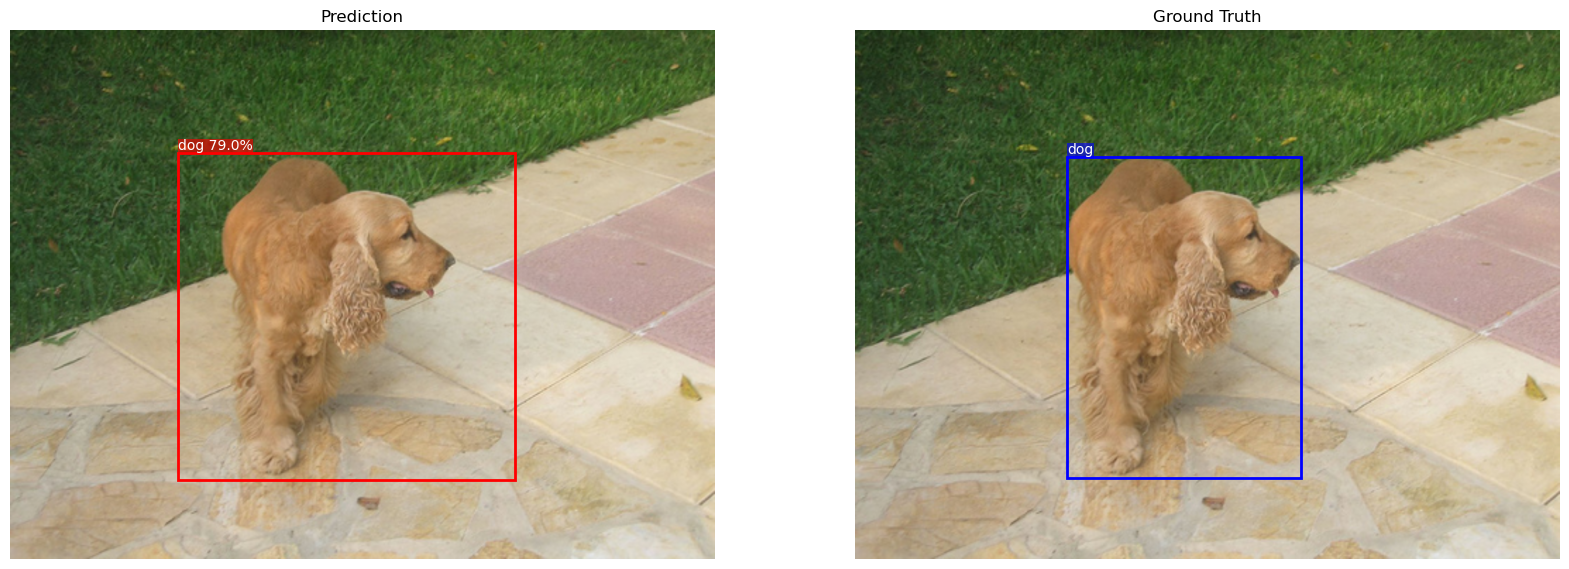

In [50]:
mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])


def plot_img(img_tensor, ax):
    inverted_image = img_tensor.cpu() * std.view(-1, 1, 1) + mean.view(-1, 1, 1)
    inverted_image = inverted_image.permute(1, 2, 0).numpy()
    ax.imshow(inverted_image)


def plot_bboxes(boxes_pred, labels_pred, color, ax, score=None):
    for i, box in enumerate(boxes_pred):
        h = box[3] - box[1]
        w = box[2] - box[0]

        rect = patches.Rectangle(
        (box[0], box[1]),
        w,
        h,
        linewidth=2,
        edgecolor=color,
        facecolor='none' # Do not fill the rectangle
        )
        
        ax.add_patch(rect)

        text = LABEL_MAP_INV[labels_pred[i]]

        if score is not None:
            text += f" {round(score[i], 2) * 100}%"

        ax.text(
        box[0],
        box[1] - 5, # Position text slightly above the box
        text,
        color='white',
        fontsize=10,
        bbox=dict(facecolor=color, alpha=0.6, pad=0.3, edgecolor='none')
        )


for x, y in val_dataloader:
    # get image tensor and gt lables/bpxes
    x = x.to(device)
    gt_labels = y['labels'].numpy()
    gt_boxes = y['bboxes'].numpy()


    # forward pass
    cls_scores_pred, labels_pred, boxes_pred = rcnn(x, inf_hparmas)



    # --- Prediction image ------
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(20, 10)
    ax1.set_axis_off()
    ax2.set_axis_off()

    ax1.set_title('Prediction')
    ax2.set_title('Ground Truth')

    plot_img(x, ax1)
    plot_img(x, ax2)

    plot_bboxes(boxes_pred, labels_pred, 'r', ax1, cls_scores_pred)
    plot_bboxes(gt_boxes, gt_labels, 'b', ax2)


    plt.show()


    break


